# Controlled Bouncing Ball

Example taken from: ProbReach paper

```
mass R = ?, C = ?, H = ?

repeat {
    if H<= 0 {
        mode = 1
    }
    else {
        mode = -1
    }
}
```

Height and velocity evolve according to:
$$ \frac{d \textit{H}}{dt} = \begin{cases} v & \text{if mode = -1} \\
                                             v & \text{if mode = 1}  \end{cases} $$

$$ \frac{d \textit{v}}{dt} = \begin{cases} -g & \text{if mode = -1} \\
                                              - g - \frac{Rv + \frac{H}{C}}{m} & \text{if mode = 1}  \end{cases} $$


We try to synthesize R and 1/C.

## Original model

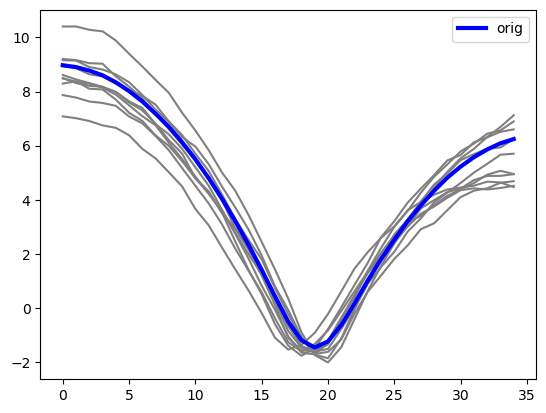

In [1]:
from cps.original_models import *

orig_params = {'T': 35,   # time steps
               'init_y': 9.,  # initial height
               'R': 5.0,
               'C': 0.0025,
               'm': 7.0}
orig_traj = generate_traj(bouncing_ball, 100, orig_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='orig')

In [2]:
#export orig_traj to csv
import pandas as pd
#consider only 20 trajectories from time 0 to 45
plot_trajectories = orig_traj[:20, 0:35]
#transpose the array so that each row is a time step and each column is a trajectory
plot_trajectories = plot_trajectories.T

df = pd.DataFrame(plot_trajectories)
df.to_csv('bouncing_ball_orig_traj.csv', index=False)

## SOGA

In [3]:
from optimization import *
torch.set_default_dtype(torch.float64)

Loss value: tensor(-2550.8521, grad_fn=<NegBackward0>)


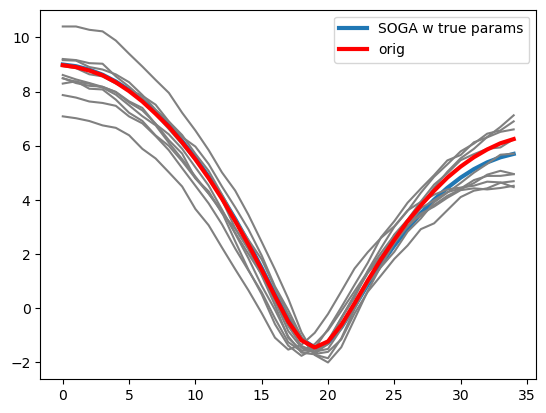

In [4]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/bouncing_ball.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_y = orig_params['init_y']
params = {'R':  7.0, 'C':400.}
#params = {'R':  7., 'C':200.}

params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# computes loss
idx=list(range(1, T))
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

Loss value: tensor(-2142.9928, grad_fn=<NegBackward0>)


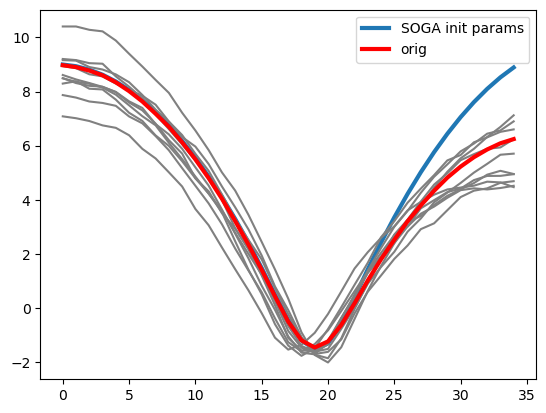

In [5]:
# we choose as initial value of the parameters values for which the loss is higher 
# and there is a significant difference in the mean trajectories

# new cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/bouncing_ball.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initial parameters
init_params = {'R':  -1., 'C':450.}
params_dict = initialize_params(init_params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# loss
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

y = []
y_var = []
for i in range(35):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('H['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('H['+ str(i) +']'), output_dist.var_list.index('H['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('bouncing_ball_init.csv', index=False)

R: -1.799999997975596 C: 449.20000000057047  loss: -2142.992785086537
R: -1.5870693671748421 C: 448.40313011349934  loss: -2152.606811303939
R: -1.1599926911056708 C: 447.606498742221  loss: -2163.9602649210765
R: -0.7341838401727453 C: 446.80873108475174  loss: -2175.7701439294597
R: -0.47305199428013023 C: 446.0091821628595  loss: -2186.4385552169015
R: -0.4129077494144896 C: 445.20798649572856  loss: -2196.7513433795457
R: -0.481427257561546 C: 444.4059083186983  loss: -2207.6494180030813
R: -0.5868763625827437 C: 443.6039842832489  loss: -2218.7557102127053
R: -0.6395571596914613 C: 442.8032287810153  loss: -2229.479444582129
R: -0.5814279134083129 C: 442.0043468460074  loss: -2239.8250355526375
R: -0.4120464170882584 C: 441.20743714556374  loss: -2250.261260053229
R: -0.1675461869765813 C: 440.41199054376744  loss: -2260.9888096632353
R: 0.1010825720150681 C: 439.61714646596425  loss: -2271.769714240485
R: 0.3395393230677485 C: 438.8220668355374  loss: -2282.3196358692207
R: 0.508

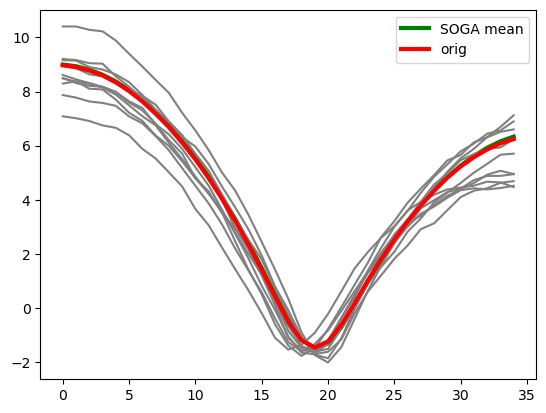

In [6]:
# Optimization in SOGA


# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(init_params)

# Define loss
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/bouncing_ball.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=100, lr=0.8)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/bouncing_ball.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

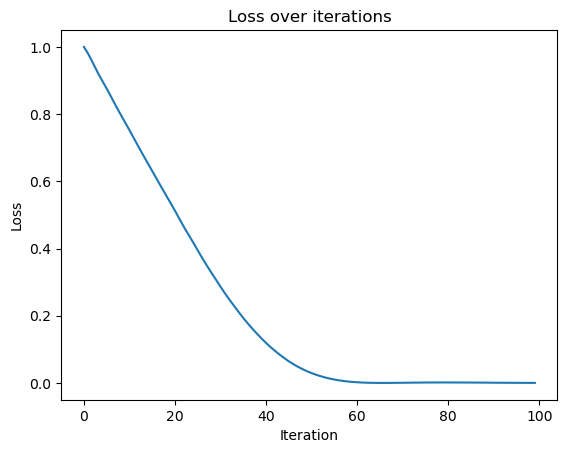

In [7]:
# export loss_list to csv
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))

df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('bouncing_ball_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

In [8]:
y = []
y_var = []
for i in range(35):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('H['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('H['+ str(i) +']'), output_dist.var_list.index('H['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('bouncing_ball_opt.csv', index=False)